<a href="https://colab.research.google.com/github/amaanhash/Profanity-Filter-for-kids-using-video-sharing-platform/blob/main/FaceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D,Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

!unzip '/content/drive/MyDrive/archive (2).zip'

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [4]:
BASE_DIR= '/content/UTKFace'
age_labels =[]
gender_labels=[]
image_paths = []

image_filenames =os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR,image)
  img_components =image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  #append the image_path,age_label and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)


  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [6]:
import pandas as pd
df =pd.DataFrame()
df['image_path'],df['age'],df['gender'] = image_paths,age_labels,gender_labels
df.head(5)

,image_path,age,gender
0,/content/UTKFace/60_1_0_20170117174613438.jpg....,60,1
1,/content/UTKFace/60_0_0_20170120225049193.jpg....,60,0
2,/content/UTKFace/27_0_3_20170119194353859.jpg....,27,0
3,/content/UTKFace/28_0_3_20170119194430402.jpg....,28,0
4,/content/UTKFace/26_1_2_20170116175501158.jpg....,26,1


<Axes: xlabel='age', ylabel='Density'>

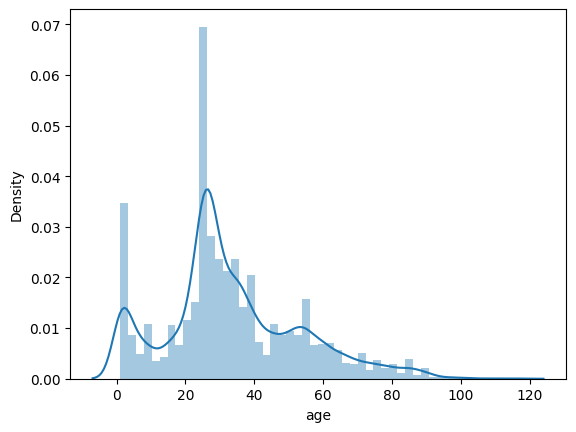

In [7]:
#Age distribution
sns.distplot(df['age'])

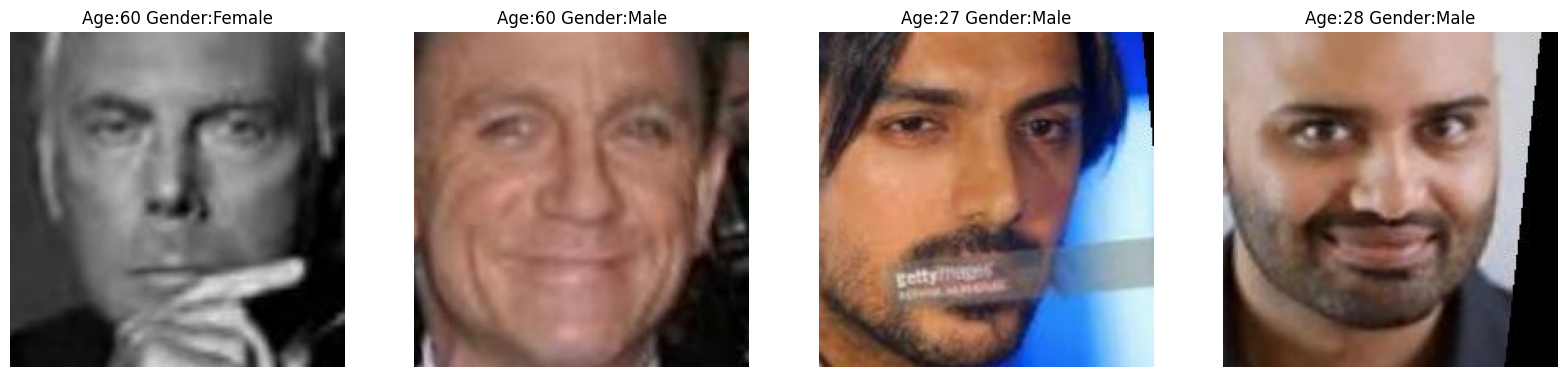

In [8]:
plt.figure(figsize=(20,20))
samples = df.iloc[0:4]

for index,sample,age,gender in samples.itertuples():
  plt.subplot(4,4,index+1)
  img =load_img(sample)
  img = np.array(img)
  plt.axis('off')
  plt.title(f'Age:{age} Gender:{gender_mapping[gender]}')
  plt.imshow(img)

feature extraction

In [9]:
from PIL import Image
def extract_image_features(images):
  features = list()

  for image in tqdm(images):
    img = load_img(image,grayscale =True)
    img = img.resize((128,128),Image.ANTIALIAS)
    img = np.array(img)
    features.append(img)

  features = np.array(features)
  features = features.reshape(len(features),128,128,1)
  return features



In [10]:
X = extract_image_features(df['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [11]:
X.shape

(23708, 128, 128, 1)

In [12]:
X = X /225.0

In [13]:
import pandas as pd
import numpy as np
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [14]:
input_shape = (128,128,1)

In [15]:
inputs =Input((input_shape))
conv_1 = Conv2D(32,kernel_size=(3,3),activation = 'relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(64,kernel_size=(3,3),activation = 'relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(128,kernel_size=(3,3),activation = 'relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(256,kernel_size=(3,3),activation = 'relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

flatten = Flatten()(max_4)

#fully connected layers

dense_1 = Dense(256,activation ='relu')(flatten)
dense_2 = Dense(256,activation ='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1,activation = 'sigmoid',name='gender_out')(dropout_1)
output_2 = Dense(1,activation = 'relu',name='age_out')(dropout_2)

model = Model(inputs=[inputs],outputs = [output_1,output_2])

model.compile(loss=['binary_crossentropy','mae'],
     optimizer = 'adam',metrics=['accuracy'])

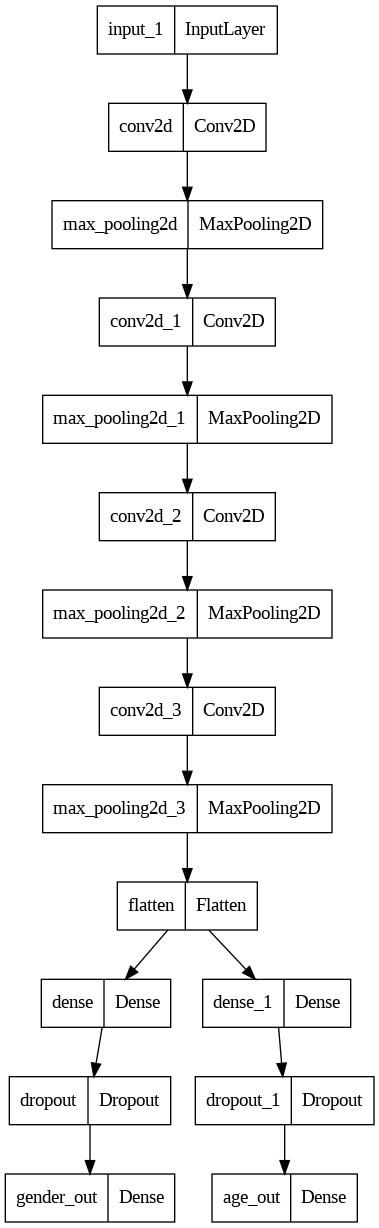

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0]']   

In [ ]:

history = model.fit(x=X,y=[y_gender,y_age],batch_size =32,
                    epochs=11,validation_split=0.2)


Epoch 1/11
593/593 [==============================] - 774s 1s/step - loss: 15.1662 - gender_out_loss: 0.6638 - age_out_loss: 14.5024 - gender_out_accuracy: 0.5806 - age_out_accuracy: 0.0458 - val_loss: 12.2651 - val_gender_out_loss: 0.5356 - val_age_out_loss: 11.7295 - val_gender_out_accuracy: 0.7353 - val_age_out_accuracy: 0.0363
Epoch 2/11
593/593 [==============================] - 758s 1s/step - loss: 11.2446 - gender_out_loss: 0.4847 - age_out_loss: 10.7599 - gender_out_accuracy: 0.7681 - age_out_accuracy: 0.0282 - val_loss: 10.0464 - val_gender_out_loss: 0.4148 - val_age_out_loss: 9.6316 - val_gender_out_accuracy: 0.8062 - val_age_out_accuracy: 0.0202
Epoch 3/11
593/593 [==============================] - 757s 1s/step - loss: 9.4765 - gender_out_loss: 0.4121 - age_out_loss: 9.0644 - gender_out_accuracy: 0.8080 - age_out_accuracy: 0.0167 - val_loss: 8.5661 - val_gender_out_loss: 0.3492 - val_age_out_loss: 8.2169 - val_gender_out_accuracy: 0.8408 - val_age_out_accuracy: 0.0059
Epoch 